# (some) Text mining for Perx Reward Dataset

In [1]:
__input_PATH = '/Users/ito/venv/CG-RecoEng/reward-text/'
__output_PATH = '/Users/ito/venv/CG-RecoEng/reward-text/'

In [2]:
import pandas as pd
import concurrent.futures as cf
from collections import Counter

reward_1 = pd.read_csv(__input_PATH+'merchant_items__17_12_12.csv', engine='c', header=None)
reward_1.columns = ['index','ID','Rewards','Description']
reward_1.head(5)

,index,ID,Rewards,Description
0,1,257,1 Free 6-inch Classic Sub (Far East Square),SUBWAY restaurants is the world’s largest subm...
1,2,258,1 Free Any Size Drink (see details for locations),Please note that you may collect chops up unti...
2,3,258,Free Any Size Drink (CBD Locations Only),Welcome to the first Perx CHOP MOB. Chop at an...
3,4,259,1 Free Curry Puff (see details for locations),Polar Puffs &amp; Cakes is widely known and ch...
4,5,260,1 Free Small Yogurt (Tier 2/2),Red Mango is a frozen yogurt and smoothie bran...


### little processing to strip the '(' and ')', while split word using white space (same in PatSnap)

In [3]:
temp_dict = dict()

temp_splits = []
def create_splits(input):
#     if input == np.isnan():
#         return []
    
    splits = input.split(' ')
    
    for idx, word in enumerate(splits):
        if word.find('(')!=-1:
            splits[idx] = word.strip('(')
        elif word.find(')')!=-1:
            splits[idx] = word.strip(')')
        splits[idx] = splits[idx].lower()
    
    return splits
#     for word in splits:
#         print word
#         if word in temp_dict:
#             temp_dict[input] += 1
#         else:
#             temp_dict.update({word: 0})

In [4]:
reward_1['Splits'] = reward_1.Rewards.map(create_splits)
reward_1.head()

,index,ID,Rewards,Description,Splits
0,1,257,1 Free 6-inch Classic Sub (Far East Square),SUBWAY restaurants is the world’s largest subm...,"[1, free, 6-inch, classic, sub, far, east, squ..."
1,2,258,1 Free Any Size Drink (see details for locations),Please note that you may collect chops up unti...,"[1, free, any, size, drink, see, details, for,..."
2,3,258,Free Any Size Drink (CBD Locations Only),Welcome to the first Perx CHOP MOB. Chop at an...,"[free, any, size, drink, cbd, locations, only]"
3,4,259,1 Free Curry Puff (see details for locations),Polar Puffs &amp; Cakes is widely known and ch...,"[1, free, curry, puff, see, details, for, loca..."
4,5,260,1 Free Small Yogurt (Tier 2/2),Red Mango is a frozen yogurt and smoothie bran...,"[1, free, small, yogurt, tier, 2/2]"


In [5]:
def sum_splits(series):
    all_splits = []
    for each_row in series:
        all_splits += each_row
    return all_splits

all_words = sum_splits(reward_1.Splits)

In [6]:
all_words_counter = Counter(all_words)
all_words_counter = all_words_counter.most_common()
all_words_list = list(all_words_counter)
a,b = zip(*all_words_list)

In [7]:
word_freq_df = pd.DataFrame([a,b]).T
word_freq_df.head()

,0,1
0,free,1283
1,1,1104
2,off,807
3,-,601
4,of,392


In [8]:
word_freq_df.to_csv(__output_PATH + 'word_freq.csv',header = False, index = False)

In [9]:
# # reward_1.Description.replace(np.isnan(),' ')
# reward_1['Splits_desc'] = reward_1.Description.map(create_splits)
# all_desc_words = sum_splits(reward_1.Splits_desc)

## General co-occurence (can be templated) with efficiency improved 

In [10]:
# For current use, the efficiency is okay since it is a simple bi-loop token detection. （feel that this will be expensive when feed a large description）
# Usually we give the window_size as 2, also note that such way is only for "word" rather than "phrase"
def co_occurrances(idx, tokens, window_size): # calculate 

    # take a window according to window size
    window = tokens[idx:idx+window_size]
    
    # Pop first word as the 1st token
    first_token = window.pop(0)

    # Consider all of the rest as 2nd token (archived)
    for second_token in window:
        yield first_token, second_token
        
# Pair all the considered co-occurrances
def considered_co_occurrances(splits, window_size=2, n_workers=4):

    all_considered = []
    
    # parallel calculating using ThreadPoolExecutor using future generator
    with cf.ThreadPoolExecutor(max_workers=n_workers) as executor:
        future_co_occurrances = {executor.submit(co_occurrances, idx, splits, window_size): idx 
                                 for idx in range(len(splits))}
        # extend the result from each generator
        for future in cf.as_completed(future_co_occurrances):
            try: # just in case
                all_considered.extend(future.result())
            except Exception as exc:
                print str(exc)
                continue
    return all_considered

In [11]:
def co_occurrances_count(all_pairs):
    return [(first, second, count) for (first, second), count in Counter(all_pairs).most_common()]

test_str = ['index','ID','Rewards','Description','index','ID','Rewards','Description','index','ID','index','ID','index','ID']
print test_str
print co_occurrances_count(considered_co_occurrances(test_str))

['index', 'ID', 'Rewards', 'Description', 'index', 'ID', 'Rewards', 'Description', 'index', 'ID', 'index', 'ID', 'index', 'ID']
[('index', 'ID', 5), ('ID', 'Rewards', 2), ('ID', 'index', 2), ('Description', 'index', 2), ('Rewards', 'Description', 2)]


In [12]:
reward_1['CoOccurrances'] = reward_1.Splits.map(considered_co_occurrances)
reward_1.head()

,index,ID,Rewards,Description,Splits,CoOccurrances
0,1,257,1 Free 6-inch Classic Sub (Far East Square),SUBWAY restaurants is the world’s largest subm...,"[1, free, 6-inch, classic, sub, far, east, squ...","[(6-inch, classic), (classic, sub), (free, 6-i..."
1,2,258,1 Free Any Size Drink (see details for locations),Please note that you may collect chops up unti...,"[1, free, any, size, drink, see, details, for,...","[(1, free), (for, locations), (drink, see), (s..."
2,3,258,Free Any Size Drink (CBD Locations Only),Welcome to the first Perx CHOP MOB. Chop at an...,"[free, any, size, drink, cbd, locations, only]","[(cbd, locations), (any, size), (free, any), (..."
3,4,259,1 Free Curry Puff (see details for locations),Polar Puffs &amp; Cakes is widely known and ch...,"[1, free, curry, puff, see, details, for, loca...","[(curry, puff), (for, locations), (free, curry..."
4,5,260,1 Free Small Yogurt (Tier 2/2),Red Mango is a frozen yogurt and smoothie bran...,"[1, free, small, yogurt, tier, 2/2]","[(free, small), (yogurt, tier), (small, yogurt..."


In [13]:
all_co_occu = sum_splits(reward_1.CoOccurrances)
all_co_occu_counter = Counter(all_co_occu).most_common()
all_co_occu_list = list(all_co_occu_counter)
word_pair, counts = zip(*all_co_occu_list)
c,d = zip(*word_pair)

In [14]:
co_occu_freq_df = pd.DataFrame([c,d,counts]).T
co_occu_freq_df.head()

,0,1,2
0,1,free,598
1,10%,off,114
2,for,1,105
3,next,visit,100
4,off,your,100


In [15]:
co_occu_freq_df.to_csv(__output_PATH + 'co_occurrence.csv', header = False, index = False)

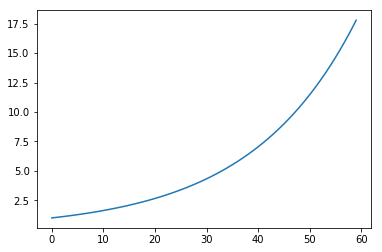

In [17]:
import matplotlib.pyplot as plt
plt.figure()
a = 60
plt.plot(range(a), [1.05**i for i in range(a)])
plt.show()

In [18]:
1.049**15

2.0494263837948195

In [19]:
7*28531

199717